### Project Overview & Goals

### Goal: 
    
Find drivers of customer churn at Telco

### Why:

Reducing churn is paramount to business brand, reputation, and profitability. Customers have access to numerous channels that can amplify a bad review and lower our NPS.  CAC can be 9x's more expensive than retention efforts.

### Overview: 

Walk through data pipeline process (acquire, prepare, explore, and modeling), conclusions, recommendations, and potentials for further investigation. 

In [6]:
# Basic Imports
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import os

# Personal Function Imports
from env import get_db_url
import acquire as a
import prepare as p
import explore as e
import model as m

# Stats and ML Imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree


### Acquire Phase

Telco data acquired from Codeup MySql\
Data has 7043 rows an 24 columns\
1526 null values in internet service type\
categories mostly objects


### Prepare Phase

In [7]:
# Acquire function nested in Prepare function calling data put into a dataframe
df=p.prep_telco()
df.head()


,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,No,Yes,...,Yes,Yes,No,Yes,65.6,593.30,No,One year,DSL,mailed check
1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,No,No,...,No,No,Yes,No,59.9,542.40,No,Month-to-month,DSL,mailed check
2,0004-TLHLJ,Male,0,No,No,4,Yes,No,No,No,...,No,No,No,Yes,73.9,280.85,Yes,Month-to-month,Fiber optic,electronic check
3,0011-IGKFF,Male,1,Yes,No,13,Yes,No,No,Yes,...,No,Yes,Yes,Yes,98.0,1237.85,Yes,Month-to-month,Fiber optic,electronic check
4,0013-EXCHZ,Female,1,Yes,No,3,Yes,No,No,No,...,Yes,Yes,No,Yes,83.9,267.40,Yes,Month-to-month,Fiber optic,mailed check


##### Changes made to data:

Duplicate Columns Dropped\
Nulls in Internet Service Type Filled with No Internet Service\
Total Charges Changed From Object to Float\
Total Charges NaNs filled with 0\
Shortened Payment Type names for Graphing Purposes

##### Prepare Phase Insights

Graphed Features to better understand data.  Decided to ignore features that are subsets of or would be dependent on a higher level feature.  For example, streaming movies and tv is dependent of Internet Service Type.  

In [8]:
# Splitting the prepped dataframe(df) into 3 sets: train, validate, test with a 60%, 20%, 20% split, respectively.
# Target variable is Churn
train, validate, test = p.split_data(df, 'churn')

In [9]:
print(f'The Training Shape is:',train.shape)
print(f'The Validate Shape is:',validate.shape)
print(f'The Test Shape is:', test.shape)

The Training Shape is: (4225, 21)
The Validate Shape is: (1409, 21)
The Test Shape is: (1409, 21)


### Explore Phase

##### Initial Hypothesis: Customers churn due to affordability, lack of speed of service, and inconvenience

> ##### Monthly charges, internet service type, contract type, and payment type are the features that most closely align to inital hypothesis.

> ##### Do the 4 identified features have a relationship to churn?

###### Consolidated Visuals

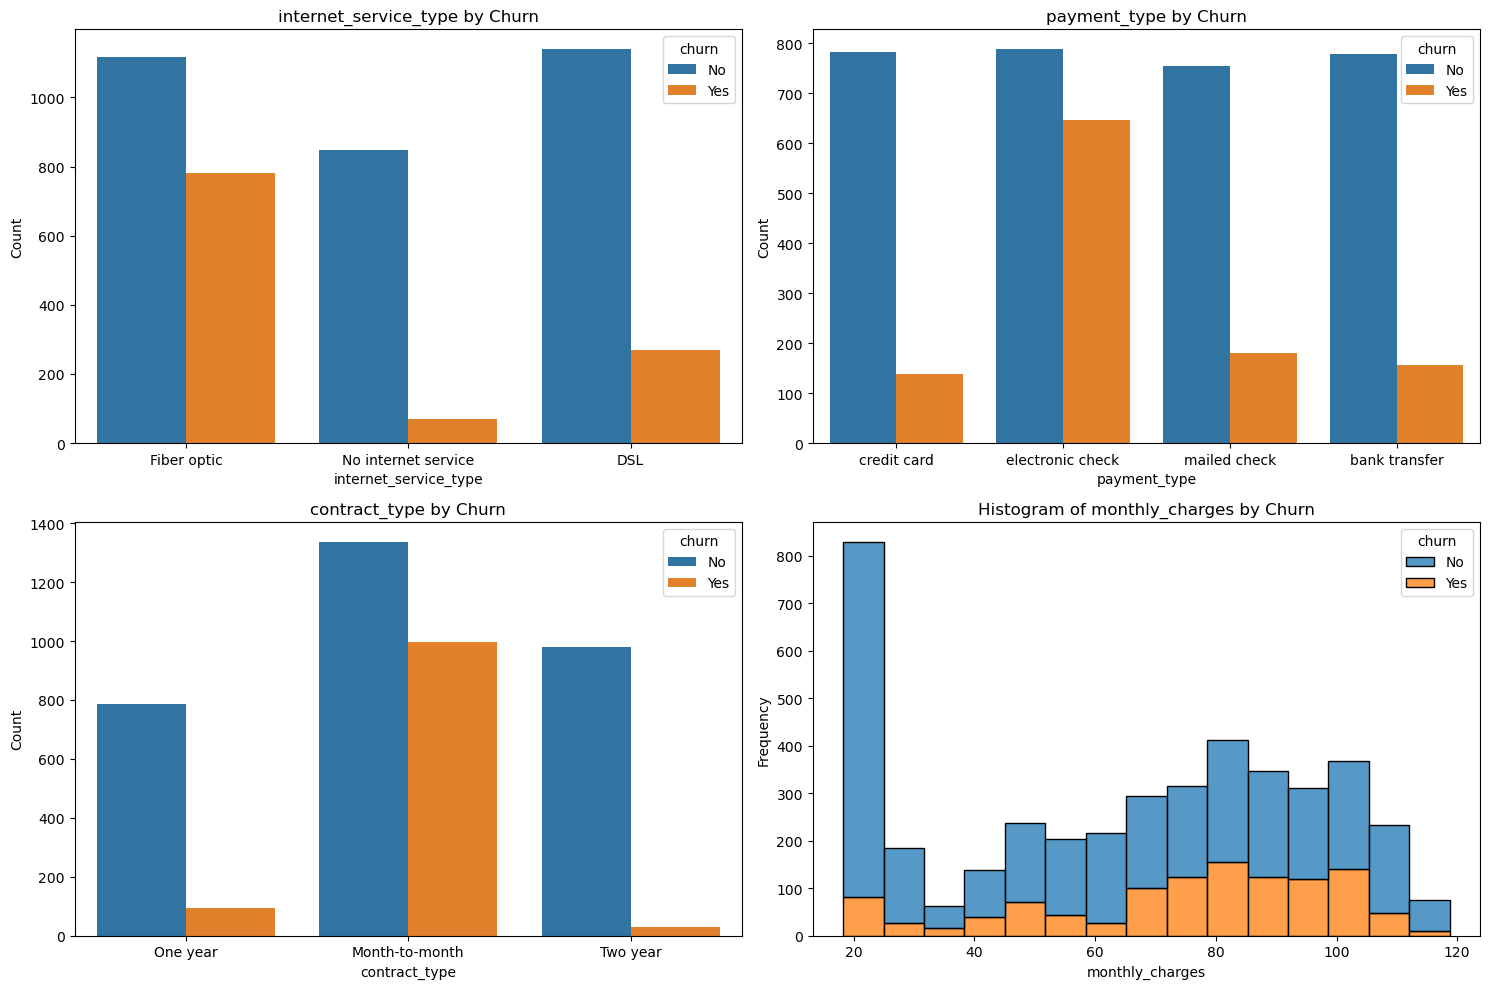

In [10]:
# Categories variable created for features examined to use in function
categories = ['internet_service_type', 'payment_type', 'contract_type', 'monthly_charges']

# Function Overview: plots dtype with appropriate visual while looping through categories and indexing axes
e.plot_categorical_by_churn(train, categories)

##### Statistical Testing

Internet Service Type, contract type, and payment type are categorical variables. Will use Chi 2 test to evaluate statistical signifigance.\
\
Null Hypthosesis:  There is no relationship between the target variable and corresponding feature(s)\
Hypothesis: there is a relationship betweent the target variable and corresponding feature(s)

In [11]:
# create categories variable with object type features
categories = ['internet_service_type', 'payment_type', 'contract_type']

# loop through categories creating category variables (cat_var) for use in explore function for Chi2 test
for cat_var in categories:
    e.explore_categorical(train, 'churn', cat_var)


internet_service_type & churn

Chi2: 417.88813854093104
P-value: 3.9804371258943206e-87
Degrees of Freedom: 6

The null hypothesis can be rejected due to statistical significance.
Ergo there is a relationship between the target variable and corresponding feature(s)

payment_type & churn

Chi2: 386.1839951483273
P-value: 1.687008595564822e-78
Degrees of Freedom: 8

The null hypothesis can be rejected due to statistical significance.
Ergo there is a relationship between the target variable and corresponding feature(s)

contract_type & churn

Chi2: 714.1745080997528
P-value: 5.320189784717562e-151
Degrees of Freedom: 6

The null hypothesis can be rejected due to statistical significance.
Ergo there is a relationship between the target variable and corresponding feature(s)


> ##### Float Category: Monthly Charges

Passed Levene Test for Equal Variance.\
Failed Shapiro Test for Normal Distribution.\
\
Ran Mann-Whitney U Stat Test

In [12]:
# Create two groups based on churn status
group_not_churn = train.monthly_charges[train.churn == 'No']
group_churn = train.monthly_charges[train.churn == 'Yes']

# Perform Mann-Whitney U test
u_statistic, mannwhitney_pvalue = stats.mannwhitneyu(group_not_churn, group_churn)

# Print the results
print('Mann-Whitney U statistic:', u_statistic)
print('Mann-Whitney U test p-value:', mannwhitney_pvalue)
print('')

# Interpret the results
α = 0.05
if mannwhitney_pvalue < α:
    print('There is a significant difference in monthly charges between churn and non-churn groups.')
else:
    print('There is no significant difference in monthly charges between churn and non-churn groups.')

Mann-Whitney U statistic: 1343343.0
Mann-Whitney U test p-value: 9.83259830397179e-30

There is a significant difference in monthly charges between churn and non-churn groups.


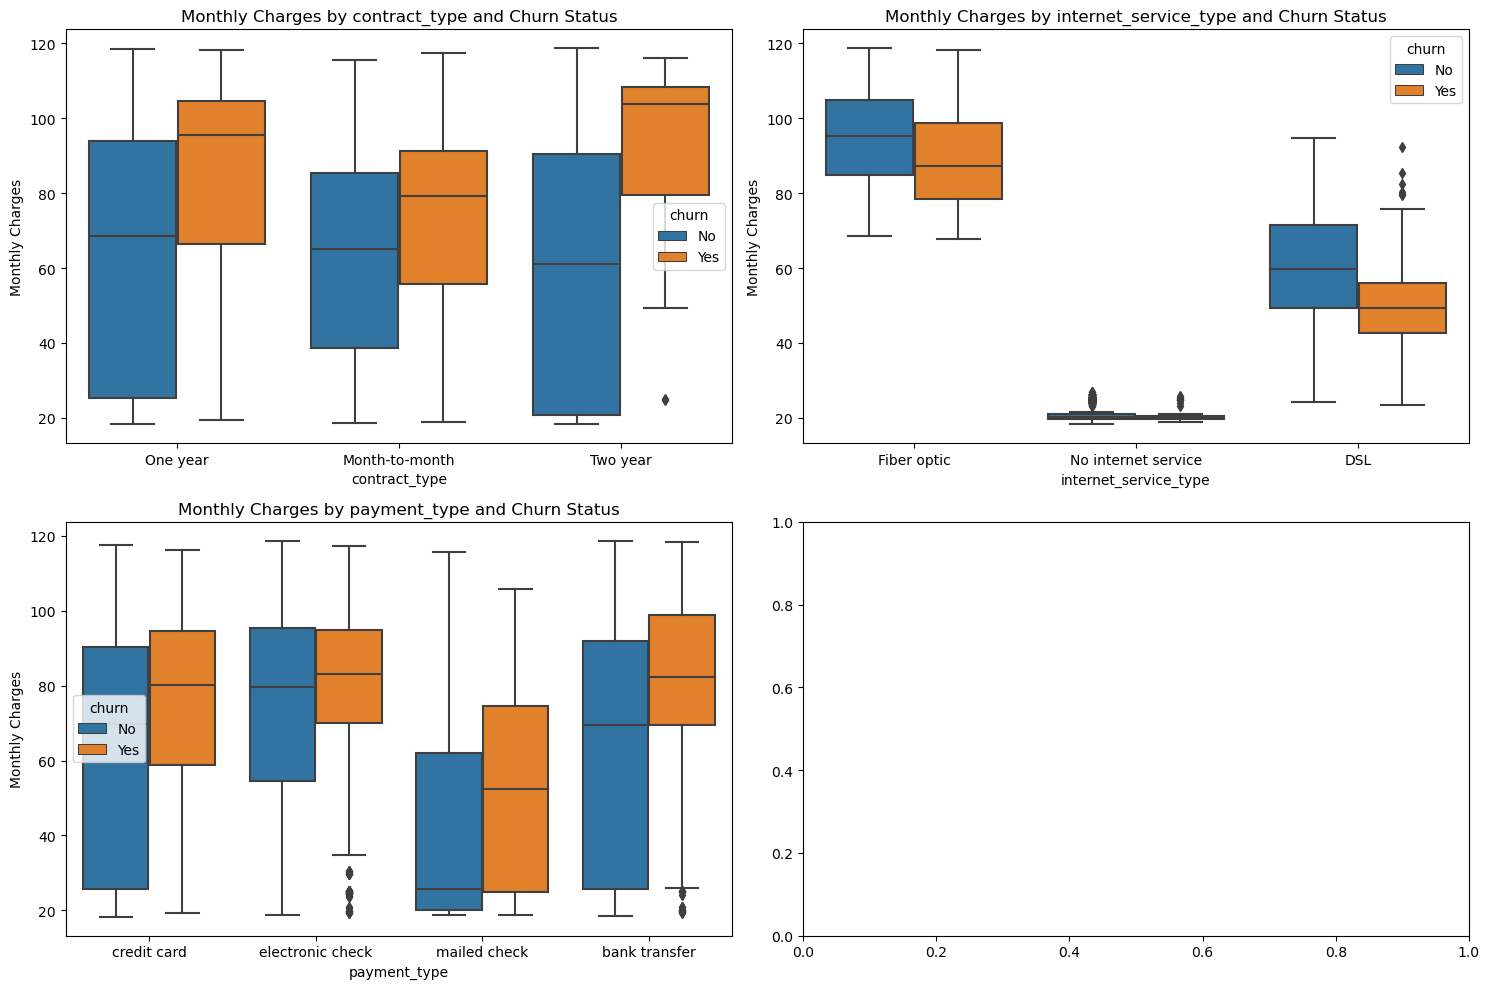

In [13]:
# subgroups variable created to use in function
subgroups = ['contract_type', 'internet_service_type', 'payment_type']

# Function Overview: Uses boxplots to loop through subgroups and examine their relationship to monthly charges 
# while indexing plots
e.plot_boxplots_by_subgroups(train, subgroups)

##### Conclusions:  
Fiber Optic is the top contributor within Internet Service Type Churn
Mailed Checks is the top contributor within Payment Type Churn
Mont-to_month is the top contributor within Contract Type
Monthly charges are not a significant contributor to churn with the monthly charge distribution.

Monthly charges seems to be a significant contributor to churn for one year and two year contracts but less so for month-to-month.
Montly charges does not appear to be a significant contributor to Fiber Optic, No Internet Service, or DSL.
Monthly charges appears to be a significant contributor to mailed check churn, credit card, and bank transfer, but not so a significant contributor to electronic check.

##### Recommendations & Potential for Further Investigation

Look into driver of Fiber Optic churn.  Fiber indicates speed and complexity.  Assumption is that there is a relationship to tech support.

Run statistical test on monthly charges to mailed check by churn.  Once confirmed assumption is that there is also a relationship to month-to-month and mailed check.  

### Modeling Phase

In [14]:
# encode objects with dummies, bin monthly_charges in ranges of 30 
train, validate, test=m.telco_encoded(train, validate, test)
train.columns

Index(['customer_id', 'senior_citizen', 'tenure', 'total_charges',
       'gender_Male', 'partner_Yes', 'dependents_Yes', 'phone_service_Yes',
       'multiple_lines_No phone service', 'multiple_lines_Yes',
       'online_security_No internet service', 'online_security_Yes',
       'online_backup_No internet service', 'online_backup_Yes',
       'device_protection_No internet service', 'device_protection_Yes',
       'tech_support_No internet service', 'tech_support_Yes',
       'streaming_tv_No internet service', 'streaming_tv_Yes',
       'streaming_movies_No internet service', 'streaming_movies_Yes',
       'paperless_billing_Yes', 'monthly_charges_30-60',
       'monthly_charges_60-90', 'monthly_charges_90-120',
       'monthly_charges_120+', 'churn_Yes', 'contract_type_One year',
       'contract_type_Two year', 'internet_service_type_Fiber optic',
       'internet_service_type_No internet service', 'payment_type_credit card',
       'payment_type_electronic check', 'payment_type_

##### Split Into Features & Target Variable (churn)

In [15]:
# Call Model.py for prep xy function which drops superfluous columns.  Limits scope to key features and their 
# dummies
X_train, y_train = m.prep_xy(train)
X_validate, y_validate = m.prep_xy(validate)
X_test, y_test = m.prep_xy(test)

##### Establish Baseline

In [16]:
# No Churn is the Mode and used to determine baseline accuracy
y_train.value_counts(normalize=True)[0]

0.7346745562130178

##### Evaluation Metric

> ##### Recall (Sensitivity): Recall is the proportion of true positive predictions among all actual positive cases. 

In [17]:
# sets max depth range 2 thru 5
max_depth_values=range(2,6)

# Function designed to loop through max depth and print classification results.  5 was found to be the optimal max
# depth with range 1- 10. Accuracy is maintained without a drop in recall
m.clf_train_validate(X_train, y_train, X_validate, y_validate, max_depth_values)

Results for max_depth=2:

Classification Report (Training):
               precision    recall  f1-score   support

           0       0.81      0.85      0.83      3104
           1       0.53      0.46      0.49      1121

    accuracy                           0.75      4225
   macro avg       0.67      0.66      0.66      4225
weighted avg       0.74      0.75      0.74      4225

Classification Report (Validation):
               precision    recall  f1-score   support

           0       0.81      0.87      0.84      1035
           1       0.54      0.42      0.47       374

    accuracy                           0.75      1409
   macro avg       0.67      0.64      0.65      1409
weighted avg       0.73      0.75      0.74      1409

Results for max_depth=3:

Classification Report (Training):
               precision    recall  f1-score   support

           0       0.81      0.88      0.85      3104
           1       0.57      0.43      0.49      1121

    accuracy           

In [18]:
# DecisionTreeClassifier for Test data with the optimal max_depth
clf = DecisionTreeClassifier(max_depth=5, random_state=42)

# Fit the model on the training data
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = clf.predict(X_test)

# Print the classification report
print('Classification Report (Test):\n', classification_report(y_test, y_pred_test))

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.82      0.90      0.85      1035
           1       0.60      0.44      0.51       374

    accuracy                           0.78      1409
   macro avg       0.71      0.67      0.68      1409
weighted avg       0.76      0.78      0.76      1409



##### Predictions

In [19]:
test.head()

,customer_id,senior_citizen,tenure,total_charges,gender_Male,partner_Yes,dependents_Yes,phone_service_Yes,multiple_lines_No phone service,multiple_lines_Yes,...,monthly_charges_90-120,monthly_charges_120+,churn_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_No internet service,payment_type_credit card,payment_type_electronic check,payment_type_mailed check
4930,6941-KXRRV,1,48,2789.70,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
117,0206-OYVOC,0,46,864.20,0,1,1,1,0,0,...,0,0,0,0,1,0,1,0,0,1
5275,7442-YGZFK,0,1,49.80,1,0,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0
6364,9018-PCIOK,0,55,3617.10,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
1092,1591-MQJTP,1,51,4839.15,1,1,0,1,0,1,...,1,0,0,1,0,1,0,0,0,0


In [20]:
# Make predictions on the test set
test_prob = clf.predict_proba(X_test)
test_pred = clf.predict(X_test)

# Create a DataFrame with predictions
pred_df = pd.DataFrame({
    'customer_id': test['customer_id'],
    'probability_of_churn': test_prob[:, 1],  # Assuming 1 is the index for the positive class
    'prediction_of_churn': test_pred
})

# Save the predictions to a CSV file
pred_df.to_csv('predictions.csv', index=False)
print('Export complete.')


Export complete.


In [21]:
pred_df.head()

,customer_id,probability_of_churn,prediction_of_churn
4930,6941-KXRRV,0.085526,0
117,0206-OYVOC,0.000000,0
5275,7442-YGZFK,0.302326,0
6364,9018-PCIOK,0.000000,0
1092,1591-MQJTP,0.154286,0
